In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import missingno as msno
import numpy as np

## Load dataset and encode variables

In [2]:
def load_and_encode(path_to_load, columns_of_interest, patients_of_interest):
    """
    Function to load a dataset given its path, to clean and encode the variables.
    
    INPUT:
        - path_to_load:                     string which specifies the path (.xlsx) of the dataset
        - columns_of_interest:              list of strings which specifies the variables of interest to extract
        - patients_of_interest:             list of strings which specifies the IDs of the patients of interest to extract
    
    OUTPUT:
        - patient_df[columns_of_interest] : filtered and encoded dataframe with patients' variables
    """
    
    patient_df = pd.read_excel(path_to_load)
    
    ### smoking status
    patient_df['smoking'] = patient_df['smoking'].replace({"yes":"current", "c":"current",
                                                            "no":"never", "no ":"never",
                                                            "never, passive":"never", "passive":"never",
                                                            "q":"quit","q ":"quit","Q":"quit",
                                                            "quit ":"quit", "former":"quit", 
                                                           "former, 1965":"quit", "former ":"quit"})
    
    # -> current smoker = 2 , former smoker = 1 , never smoker = 0
    patient_df['smoking'] = patient_df['smoking'].replace({"current":2, "never":0, "quit":1})
    
    ### sex -> M = 1 , F = 0
    patient_df['sex'] = patient_df['sex'].replace({"M":1, "F":0}) 
    
    
    ### statin_type 
    # -> no treatment = 0 , simvastati = 1 , pravastatin = 2 , atorvastatin = 3 , rosuvastatin = 4, losuvastatin = 5
    
    ### % of stenosis
    patient_df['% stenosis'] = patient_df['% stenosis'].replace({"50-69%":0, ">50":0, "50-69% right and left":0,
                                                                 "50-60%":0, ">50%":0, "12/2/19 R < 50%; L 50-69%":0,
                                                                "65% CTA":0, ">60":0,
                                                                ">69% pICA 243, ratio 4.6":1,
                                                                ">69%, pSV 253, EDV 103 ratio 4.6":1,
                                                                 "70% MRI":1, 0.7:1, "75 cta":1, "70% cta":1,
                                                                ">70%":1, ">70":1, ">69%":1, ">70% ":1,
                                                                 "50/79%":1, 
                                                                "70% CT":1, ">70% MRA, CT":1,
                                                                ">70% duplex":1,">70-80%":1,
                                                                "70 - 80% R ICA, ~50% R vertebral artery ":1,
                                                                    ">80":2, ">80%":2, ">80 us":2, "75-80":2,
                                                                    ">80%, U/S":2, ">85%":2,
                                                                ">90%":3, ">90":3, "90% CTA":3, "90% cta":3,
                                                                 90:3, "left 73%, right 96%":3,
                                                                 "99% angio":3, "90":3, 0.99:3, 0.9:3,
                                                                 "Right 60-70%; Left 90%":3, 90:3,99:3,
                                                                "99%: MR and duplex, duplex PSV 610, Ratio 9:1":3})
    
    # -> 0-> 50-69% , 1-> 70-79% , 2-> 80-89% , 3-> 90-99%
    
    # filtering on the patient of interest
    if patients_of_interest!=None:
        patient_df = patient_df[patient_df['ID'].isin(patients_of_interest)]
    
    return patient_df[columns_of_interest]

In [77]:
columns_of_interest_list = ['sex','age','smoking','% stenosis','statin_binary','statin_type','statin_dosage','ID']

Asymptomatic_P = load_and_encode("Asymptomatic_P.xlsx",columns_of_interest_list,None)
Symptomatic_P = load_and_encode("Symptomatic_P.xlsx",columns_of_interest_list,None)


# encoding check
# for c in columns_of_interest_list:
#     print(Asymptomatic_P[c].value_counts())
#     print(Symptomatic_P[c].value_counts())
#     print("\n")

patient_dataframe = pd.concat([Asymptomatic_P,Symptomatic_P])

## Missing valus inspection

In [83]:
def missing_values_inspection(datadf):
    """
    Function to visualize the missing data.
    
    INPUT:
        - datadf:                      filtered and encoded dataframe with patients' variables
    
    """
    
    datadf_onlyfeatures = datadf.copy(True)
    del datadf_onlyfeatures['ID']
    
    # missing datadf_onlyfeatures matrix plot with missingno package
    msno.matrix(datadf_onlyfeatures)
    
    # % of missing values for each variable
    for c in datadf_onlyfeatures.columns:
        print(c)
        print( ((len(datadf_onlyfeatures) - pd.notnull(datadf_onlyfeatures[c]).sum()) / len(datadf_onlyfeatures))*100 )
        print("\n")
        
    print("number of patients with all missing values: " + str(patient_dataframe.isna().all(axis=1).sum()))

sex
22.142857142857142


age
25.0


smoking
32.142857142857146


% stenosis
27.142857142857142


statin_binary
30.714285714285715


statin_type
57.14285714285714


statin_dosage
57.85714285714286


number of patients with all missing values: 1


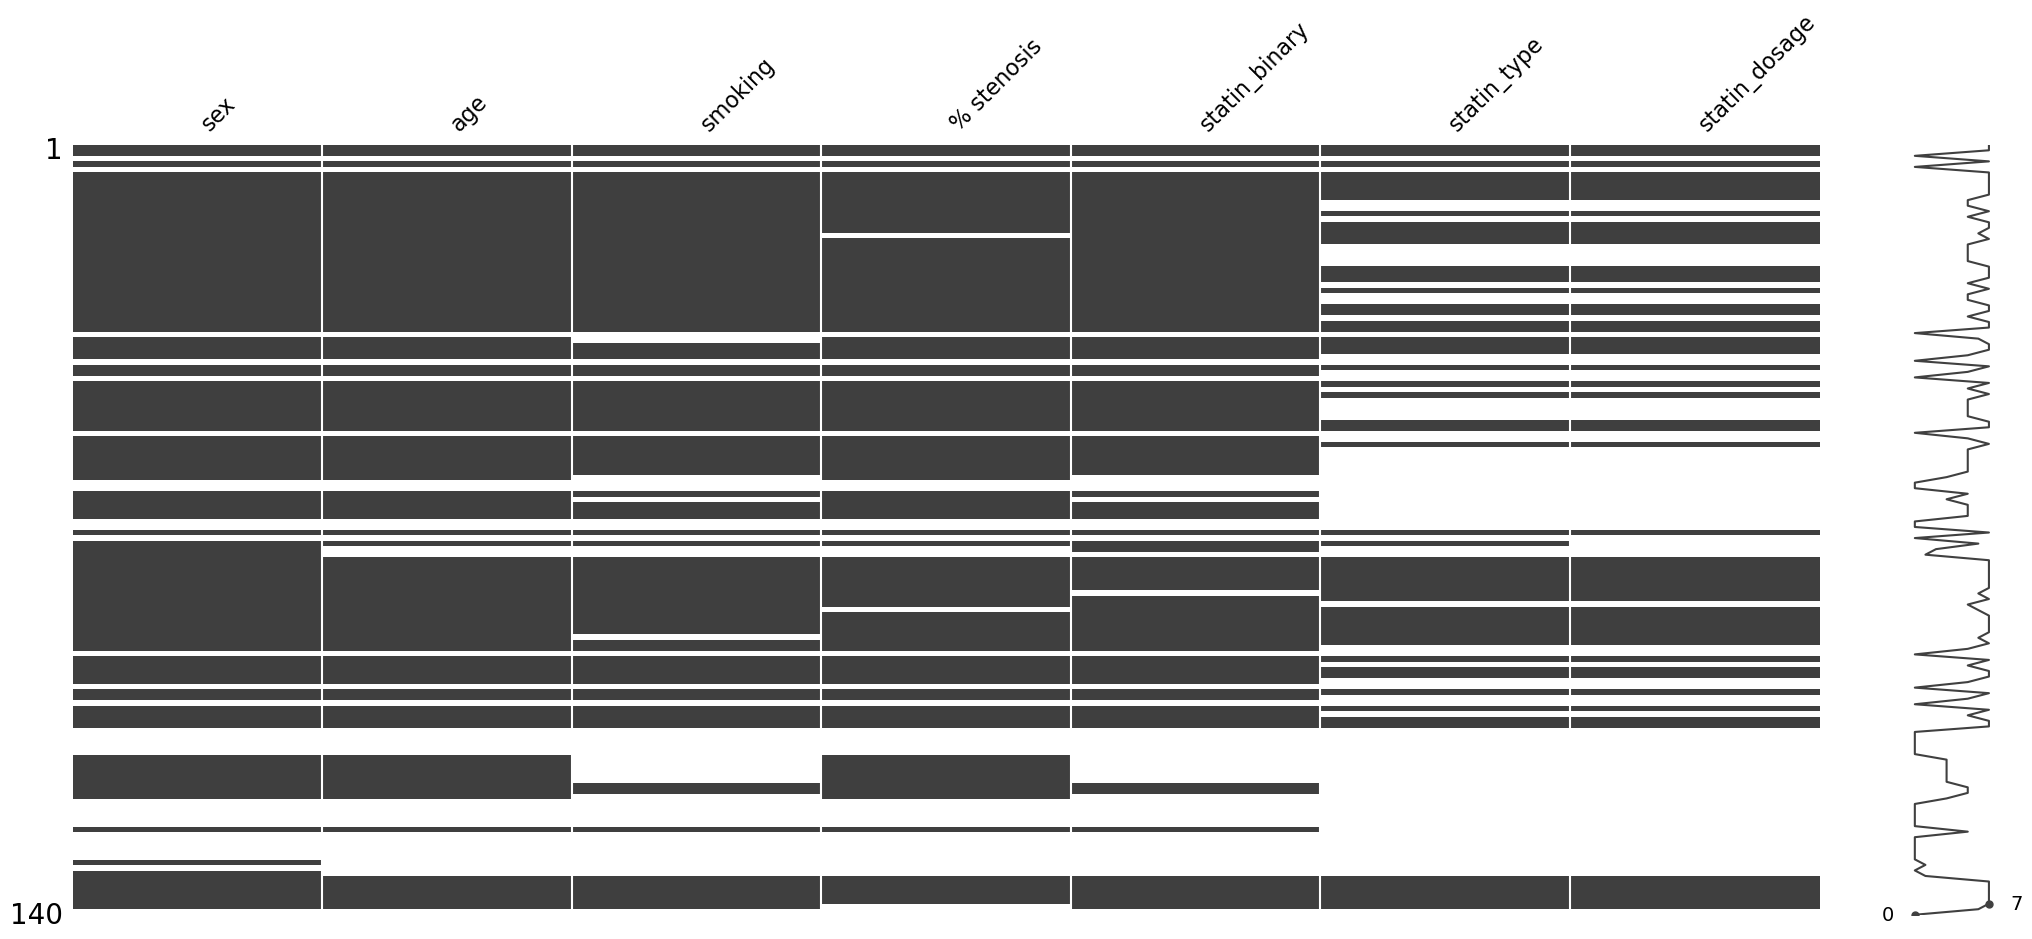

In [84]:
missing_values_inspection(patient_dataframe)

## Gower distance

In [5]:
from scipy.sparse import issparse
import numpy as np
import pandas as pd

def gower_matrix(data_x, data_y=None, weight=None, cat_features=None):  
    
    """
    Function to compute the gower distance - modified to take into account missing values
    
    Code from python gower package 
    https://github.com/wwwjk366/gower/blob/master/gower/gower_dist.py(it use the gower_get function)
    
    INPUT:
        - data_x:                     dataset as pandas df
        - cat_features:               list with string names of the categorical features
    
    OUTPUT:
        - out :                      numpy array with shape N x N containing pairwise distance between the N samples
    """
    
    # function checks
    X = data_x
    if data_y is None:
        Y = data_x 
    else:
        Y = data_y 

    if not isinstance(X, np.ndarray):
        if not np.array_equal(X.columns, Y.columns):
            raise TypeError("X and Y must have same columns!")   
    else: 
        if not X.shape[1] == Y.shape[1]:
            raise TypeError("X and Y must have same y-dim!")  
                
    if issparse(X) or issparse(Y):
        raise TypeError("Sparse matrices are not supported!")        
            
    x_n_rows, x_n_cols = X.shape
    y_n_rows, y_n_cols = Y.shape 
    
    # ---- categorical features handling ----
    if cat_features is None:
        # infer categorical from dtypes when using DataFrames
        if not isinstance(X, np.ndarray): 
            is_number = np.vectorize(lambda x: not np.issubdtype(x, np.number))
            cat_features = is_number(X.dtypes)    # boolean mask
        else:
            cat_features = np.zeros(x_n_cols, dtype=bool)
            for col in range(x_n_cols):
                if not np.issubdtype(type(X[0, col]), np.number):
                    cat_features[col] = True
    else:
        # user provided cat_features
        if not isinstance(X, np.ndarray):
            # X is a DataFrame: allow column names or boolean mask
            if isinstance(cat_features, (list, tuple, np.ndarray)):
                cat_features = np.array(cat_features)
                # if it's already a proper boolean mask of right length, keep it
                if cat_features.dtype == bool and cat_features.size == x_n_cols:
                    pass
                else:
                    # treat as column names -> convert to boolean mask
                    cat_features = X.columns.isin(cat_features)  # <-- FIXED: no .values
            else:
                raise TypeError("cat_features must be list/array of column names or boolean mask.")
        else:
            # X is a numpy array: expect boolean mask or indices
            cat_features = np.array(cat_features)
            if cat_features.dtype == bool and cat_features.size == x_n_cols:
                pass
            else:
                # assume indices of categorical columns
                mask = np.zeros(x_n_cols, dtype=bool)
                mask[np.array(cat_features, dtype=int)] = True
                cat_features = mask

    cat_features = np.array(cat_features, dtype=bool)
    
    # convert DataFrames to numpy arrays
    if not isinstance(X, np.ndarray):
        X = np.asarray(X)
    if not isinstance(Y, np.ndarray):
        Y = np.asarray(Y)
    
    Z = np.concatenate((X, Y))
    
    x_index = range(0, x_n_rows)
    y_index = range(x_n_rows, x_n_rows + y_n_rows)
    
    Z_num = Z[:, np.logical_not(cat_features)]
    
    num_cols = Z_num.shape[1]
    num_ranges = np.zeros(num_cols, dtype=np.float32)
    num_max = np.zeros(num_cols, dtype=np.float32)
    
    # compute ranges and max for numeric columns (ignoring NaNs)
    for col in range(num_cols):
        col_array = Z_num[:, col].astype(np.float32) 
        max_val = np.nanmax(col_array)
        min_val = np.nanmin(col_array)
     
        if np.isnan(max_val):
            max_val = 0.0
        if np.isnan(min_val):
            min_val = 0.0
        num_max[col] = max_val
        num_ranges[col] = np.abs(1 - min_val / max_val) if (max_val != 0) else 0.0

    # normalize numeric values between 0 and 1 using max
    Z_num = np.divide(Z_num, num_max, out=np.zeros_like(Z_num, dtype=np.float32), where=num_max != 0)
    Z_cat = Z[:, cat_features]
    
    if weight is None:
        weight = np.ones(Z.shape[1], dtype=np.float32)
    else:
        weight = np.asarray(weight, dtype=np.float32)
        
    weight_cat = weight[cat_features]
    weight_num = weight[np.logical_not(cat_features)]   
        
    out = np.zeros((x_n_rows, y_n_rows), dtype=np.float32)
        
    weight_sum = weight.sum()
    
    X_cat = Z_cat[x_index, ]
    X_num = Z_num[x_index, ]
    Y_cat = Z_cat[y_index, ]
    Y_num = Z_num[y_index, ]
    
    for i in range(x_n_rows):          
        j_start = i        
        if x_n_rows != y_n_rows:
            j_start = 0

        res = gower_get(X_cat[i, :], 
                        X_num[i, :],
                        Y_cat[j_start:y_n_rows, :],
                        Y_num[j_start:y_n_rows, :],
                        weight_cat,
                        weight_num,
                        weight_sum,
                        cat_features,
                        num_ranges,
                        num_max) 

        out[i, j_start:] = res
        if x_n_rows == y_n_rows:
            out[i:, j_start] = res
        
    return out


def gower_get(xi_cat, xi_num, xj_cat, xj_num,
              feature_weight_cat, feature_weight_num,
              feature_weight_sum, categorical_features,
              ranges_of_numeric, max_of_numeric):
    
    # ---------- CATEGORICAL COLUMNS ----------
    # base dissimilarity: 0 if equal, 1 if different
    sij_cat = np.where(
        xi_cat == xj_cat,
        np.zeros_like(xj_cat, dtype=np.float32),
        np.ones_like(xj_cat, dtype=np.float32)
    )

    # NaN handling: if NaN on either side -> contribution = 0
    xi_cat_nan = pd.isna(xi_cat)          # (n_cat,)
    xj_cat_nan = pd.isna(xj_cat)          # (n_pairs, n_cat)
    nan_mask_cat = np.logical_or(xi_cat_nan, xj_cat_nan)

    sij_cat[nan_mask_cat] = 1.0

    sum_cat = np.multiply(feature_weight_cat, sij_cat).sum(axis=1)

    # ---------- NUMERICAL COLUMNS ----------
    abs_delta = np.absolute(xi_num - xj_num)  # (n_pairs, n_num)
    sij_num = np.divide(
        abs_delta,
        ranges_of_numeric,                     # (n_num,)
        out=np.zeros_like(abs_delta, dtype=np.float32),
        where=ranges_of_numeric != 0
    )

    # NaN handling: if NaN on either side -> contribution = 0
    xi_num_nan = pd.isna(xi_num)         # (n_num,)
    xj_num_nan = pd.isna(xj_num)         # (n_pairs, n_num)
    nan_mask_num = np.logical_or(xi_num_nan, xj_num_nan)

    sij_num[nan_mask_num] = 1.0

    sum_num = np.multiply(feature_weight_num, sij_num).sum(axis=1)

    # ---------- COMBINE ----------
    sums = np.add(sum_cat, sum_num)
    sum_sij = np.divide(sums, feature_weight_sum)

    return sum_sij


In [94]:
patient_dataframe['ID'].loc[98]

KeyError: 98

<AxesSubplot:>

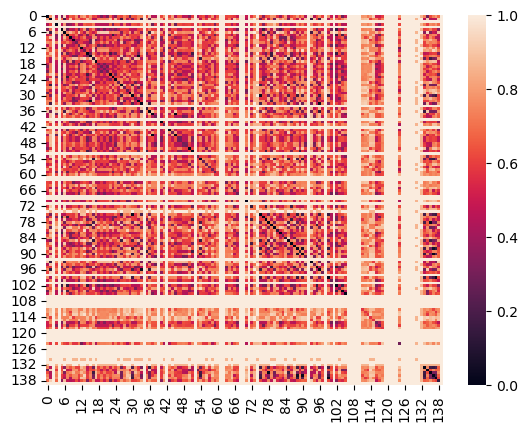

In [95]:
## Example: computing distances and visualize with seaborn heatmap 

patientdf_onlyfeatures = patient_dataframe.copy(True)
del patientdf_onlyfeatures['ID']

mapping_dict = {}
for i in range(len(patient_dataframe)):
    mapping_dict[i] = patient_dataframe['ID'].iloc[i]
    
patients_distance = gower_matrix(patientdf_onlyfeatures, cat_features=['sex','smoking','% stenosis','statin_binary','statin_type','statin_dosage'])

sb.heatmap(patients_distance)

## Patient graph creation with PyG

In [103]:
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

patients_similarity = 1 - patients_distance

# Step 1: all i < j pairs
N = patients_similarity.shape[0]
row, col = np.triu_indices(N, k=1)
sim_vals = patients_similarity[row, col]

# Step 2: filter out similarity == 0
mask = sim_vals > 0
row = row[mask]
col = col[mask]
sim_vals = sim_vals[mask]

# Step 3: build undirected edges (i→j and j→i)
edge_index = np.hstack([
    np.vstack([row, col]),   # i → j
    np.vstack([col, row])    # j → i
]).astype(np.int64)

edge_attr = np.vstack([
    sim_vals.reshape(-1, 1),  # for i → j
    sim_vals.reshape(-1, 1)   # for j → i
]).astype(np.float32)

# Step 4: convert to torch tensors
edge_index = torch.tensor(edge_index, dtype=torch.long)
edge_attr  = torch.tensor(edge_attr, dtype=torch.float)

# Create the PyG graph
patient_graph_pyg = Data(
    edge_index=edge_index,
    edge_attr=edge_attr,
    mapping_node_patientID = mapping_dict,
    x = torch.zeros((len(mapping_dict),256),dtype=torch.float32)
)

# Optionally convert to networkx
patient_graph_networkx = to_networkx(patient_graph_pyg,to_undirected=False)


<AxesSubplot:title={'center':'Histogram with similarities between the patients'}, ylabel='Count'>

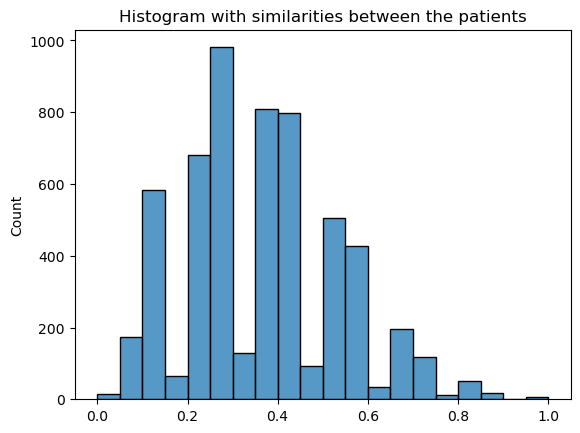

In [26]:
plt.title("Histogram with similarities between the patients")
sb.histplot(unique_distances,bins=np.linspace(0,1,21))

In [ ]:
## dictionaries that hold IDs and count:

## - unique_patients with their ID
## - unique_images (506?) with their ID
## mapping_patients_images that map patient ID to a [list of images ID]
##
## - unique_patches from all the images
## mapping_patches_images that map a [list of patches] to the image they belong trough images ID

## Dataset as used before, in which each image is a graph G (nodes are patches)

In [ ]:
from torch_geometric.data import HeteroData

def create_HeteroData(patients_graph):
    
    Heterogeneous_graph_images_patients = HeteroData()
    
    headentity_relationname_tailentity = [['patient','PatientIsSimilarToPatient','patient'],
                                         ['patch','PatchIsStructurallyConnectedToPatch','patch'],
                                         ['patch','PatchBelongToImage','image'],
                                         ['image','ImageBelongToPatient','patient']]
    
    
    # add patient graph nodes, number of nodes, edge index and attribute by using PatientIsSimilarToPatient
    Heterogeneous_graph_images_patients['patient'].x = patients_graph['x']
    Heterogeneous_graph_images_patients['patient'].num_nodes = len(patients_graph.mapping_node_patientID)
    Heterogeneous_graph_images_patients['patient','PatientIsSimilarToPatient','patient'].edge_index = patients_graph['edge_index']
    Heterogeneous_graph_images_patients['patient','PatientIsSimilarToPatient','patient'].edge_attr = patients_graph['edge_attr']
    
    
    ######### ImageBelongToPatient 
    
    # edge_tensors_list_ImageBelongToPatient = []
    # for each patient-[list of images] in mapping_patients_images:
    #     for each image in [list of images]
    #         edge_tensors_list_ImageBelongToPatient.append(torch.tensor([[ unique_images[image], unique_patients[patient] ]], dtype=torch.long))
    
    # edge_tensors_ImageBelongToPatient = torch.cat(edge_tensors_list_ImageBelongToPatient,dim=0)
    # Heterogeneous_graph_images_patients['image','ImageBelongToPatient','patient'].edge_index = edge_tensors_ImageBelongToPatient.t().contiguous()
   
    #### add also image features (zero initialized and num of images)
    # Heterogeneous_graph_images_patients['image'].x = torch.zeros((len(unique_images),256),dtype=torch.float32)
    # Heterogeneous_graph_images_patients['image'].num_nodes = len(unique_images)
    
    
    ######### PatchBelongToImage
    
    # edge_tensors_list_PatchBelongToImage = []
    # for each [list of patches]-image in mapping_patches_images:
    #     for each patch in [list of patches]
    #         edge_tensors_list_PatchBelongToImage.append(torch.tensor([[ unique_patches[patch], unique_images[image] ]], dtype=torch.long))
    
    # edge_tensors_PatchBelongToImage = torch.cat(edge_tensors_list_PatchBelongToImage,dim=0)
    # Heterogeneous_graph_images_patients['patch','PatchBelongToImage','image'].edge_index = edge_tensors_PatchBelongToImage.t().contiguous()
    
    
    ######### PatchIsStructurallyConnectedToPatch
    
    # Heterogeneous_graph_images_patients['patch','PatchIsStructurallyConnectedToPatch','patch'].edge_index = G['edge_index']
    
    # at the same time we add patches features
    # patch_nodes_features = []
    
    # for patch_feature in G.x:
    #     patch_nodes_features.append(patch_feature.reshape(1,-1))
    
    # Heterogeneous_graph_images_patients['patch'].x = torch.cat(patch_nodes_features,dim=0)
    # Heterogeneous_graph_images_patients['patch'].num_nodes = len(unique_patches)

    # if you want to save the graph
    # torch.save(Heterogeneous_graph_images_patients,"./Heterogeneous_graph_images_patients.pt")
    
    return Heterogeneous_graph_images_patients